In [1]:
import sys
import h5py
sys.path.append("/users/munozr/mycodes")
import numpy as np
import matplotlib.pyplot as plt
from data_analysis_codes.tools import Cstyle
plt.style.use(Cstyle.style1)
from data_analysis_codes.tools import ReadingTools as RRead
from data_analysis_codes.tools import LinData
import pandas as pd
from data_analysis_codes.tools import NumMethods
from data_analysis_codes.tools import GetVars_Plot2d as GVar

In [2]:
def get_1ddata(param, f, name, key, it):
        fkey = name + '::{} it={} tl=0'.format(key, it)
        fkey = fkey + ' rl={}'.format(param['max_refinement_levels'] - 1)
        data = RRead.fixij(f[fkey])
        data = RRead.cut0(data, param['ghost_size'], param['Nx'])
        return data

In [3]:
paramA = RRead.read_parameters('pflrw_d3e2_L1821_t1_N128_LCDM')
fA = pd.read_table(paramA['datapath']+'h5_data.csv', delimiter=',')

In [4]:
param = RRead.read_parameters('pflrw_d3e2_L1821_t1_N64_LCDM_withlapse_1plog_pfix')
Lin = LinData.LinData_Class(param)
fdata = pd.read_table(param['datapath']+'h5_data.csv', delimiter=',')
fc = pd.read_table(param['datapath']+'constraints.csv', delimiter=',')
GV = GVar.Get_var(param, Lin)
it_file_name = param['h5datapath'] + param['simname']

 read time file


# Look at spatial metric

In [4]:
it = 1000
f = h5py.File('{}_it_{:06d}.hdf5'.format(it_file_name, it), 'r') 
metric_dict = GV.get_the_metric(f, it)
metric_dict.keys()

dict_keys(['gdown', 'gdet', 'gup', 'gmixed'])

In [6]:
alpha = get_1ddata(param, f, 'ADMBASE', 'alp', it)
alpha2 = alpha**2
gdown = metric_dict['gdown']
Box0 = np.zeros(np.shape(gdown[0,0]))
gdown4 = np.array([[-alpha2, Box0, Box0, Box0],
                   [Box0, gdown[0,0], gdown[0,1], gdown[0,2]],
                   [Box0, gdown[1,0], gdown[1,1], gdown[1,2]],
                   [Box0, gdown[2,0], gdown[2,1], gdown[2,2]]])

In [7]:
u1down = get_1ddata(param, f, 'CT_DUST', 'u1', it)
u2down = get_1ddata(param, f, 'CT_DUST', 'u2', it)
u3down = get_1ddata(param, f, 'CT_DUST', 'u3', it)
W = get_1ddata(param, f, 'CT_DUST', 'W', it) / np.sqrt(metric_dict['gdet'])
u0up = W / alpha
u0down = -alpha2 * u0up # Change this if Beta present
udown4 = np.array([u0down, u1down, u2down, u3down])

In [8]:
hdown = gdown4 + np.einsum('a...,b...->ab...', udown4, udown4)

In [11]:
gdown4[:,:, 7, 7, 7], np.einsum('a...,b...->ab...', udown4, udown4)[:,:, 7, 7, 7], hdown[:,:, 7, 7, 7]

(array([[-1.96914349e+02,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  8.60394171e-04,  8.46495140e-07,
          8.46514784e-07],
        [ 0.00000000e+00,  8.46495140e-07,  8.60394200e-04,
          8.46495218e-07],
        [ 0.00000000e+00,  8.46514784e-07,  8.46495218e-07,
          8.60394174e-04]]),
 array([[1.96950358e+02, 3.21709361e-03, 3.21709255e-03, 3.21709109e-03],
        [3.21709361e-03, 5.25497459e-08, 5.25497287e-08, 5.25497047e-08],
        [3.21709255e-03, 5.25497287e-08, 5.25497115e-08, 5.25496875e-08],
        [3.21709109e-03, 5.25497047e-08, 5.25496875e-08, 5.25496636e-08]]),
 array([[3.60095527e-02, 3.21709361e-03, 3.21709255e-03, 3.21709109e-03],
        [3.21709361e-03, 8.60446721e-04, 8.99044869e-07, 8.99064488e-07],
        [3.21709255e-03, 8.99044869e-07, 8.60446749e-04, 8.99044905e-07],
        [3.21709109e-03, 8.99064488e-07, 8.99044905e-07, 8.60446724e-04]]))

In [13]:
RRead.det4(hdown)[7, 7, 7]

-4.479376887430712e-23

# Look at gauge speed

In [5]:
it = 1000
f = h5py.File('{}_it_{:06d}.hdf5'.format(it_file_name, it), 'r') 
metric_dict = GV.get_the_metric(f, it)
metric_dict.keys()
alpha = get_1ddata(param, f, 'ADMBASE', 'alp', it)  

In [7]:
vg = alpha * np.sqrt(2*np.einsum('ii...->...', metric_dict['gdown'])/alpha)

In [9]:
all_it, all_t = RRead.collect_iteration_and_time(param['datapath'])
all_hdf5it = all_it[0::param['IOHDF5::out_every']]

In [15]:
vgOD = []
vgUD = []
vlOD = []
vlUD = []
idOD = int(param['Nx']/4)
idUD = int(3*param['Nx']/4)
for it in all_hdf5it[0::4]:
    f = h5py.File('{}_it_{:06d}.hdf5'.format(it_file_name, it), 'r') 
    metric_dict = GV.get_the_metric(f, it)
    alpha = get_1ddata(param, f, 'ADMBASE', 'alp', it)  
    vg = alpha * np.sqrt(2*metric_dict['gdown'][0,0]/alpha)
    vl = alpha * np.sqrt(metric_dict['gdown'][0,0])
    vgOD += [vg[idOD, idOD, idOD]]
    vgUD += [vg[idUD, idUD, idUD]]
    vlOD += [vl[idOD, idOD, idOD]]
    vlUD += [vl[idUD, idUD, idUD]]

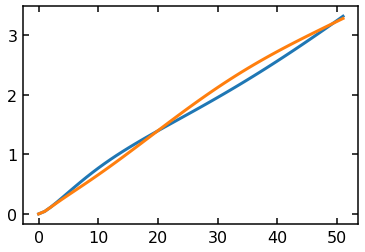

In [16]:
plt.plot(vgOD)
plt.plot(vgUD)

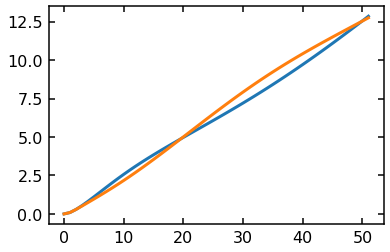

In [17]:
plt.plot(vlOD)
plt.plot(vlUD)

# Look at expansion

In [5]:
it = 1000
f = h5py.File('{}_it_{:06d}.hdf5'.format(it_file_name, it), 'r') 
metric_dict = GV.get_the_metric(f, it)
ricci_dict = GV.get_the_ricci(f, it)

In [6]:
f.keys(), metric_dict.keys(), ricci_dict.keys()

(<KeysViewHDF5 ['ADMBASE::alp it=1000 tl=0 rl=0', 'ADMBASE::gxx it=1000 tl=0 rl=0', 'ADMBASE::gxy it=1000 tl=0 rl=0', 'ADMBASE::gxz it=1000 tl=0 rl=0', 'ADMBASE::gyy it=1000 tl=0 rl=0', 'ADMBASE::gyz it=1000 tl=0 rl=0', 'ADMBASE::gzz it=1000 tl=0 rl=0', 'ADMBASE::kxx it=1000 tl=0 rl=0', 'ADMBASE::kxy it=1000 tl=0 rl=0', 'ADMBASE::kxz it=1000 tl=0 rl=0', 'ADMBASE::kyy it=1000 tl=0 rl=0', 'ADMBASE::kyz it=1000 tl=0 rl=0', 'ADMBASE::kzz it=1000 tl=0 rl=0', 'CT_DUST::DD it=1000 tl=0 rl=0', 'CT_DUST::SS1 it=1000 tl=0 rl=0', 'CT_DUST::SS2 it=1000 tl=0 rl=0', 'CT_DUST::SS3 it=1000 tl=0 rl=0', 'CT_DUST::V1 it=1000 tl=0 rl=0', 'CT_DUST::V2 it=1000 tl=0 rl=0', 'CT_DUST::V3 it=1000 tl=0 rl=0', 'CT_DUST::W it=1000 tl=0 rl=0', 'CT_DUST::rho it=1000 tl=0 rl=0', 'CT_DUST::u1 it=1000 tl=0 rl=0', 'CT_DUST::u2 it=1000 tl=0 rl=0', 'CT_DUST::u3 it=1000 tl=0 rl=0', 'TMUNUBASE::eTtt it=1000 tl=0 rl=0', 'TMUNUBASE::eTtx it=1000 tl=0 rl=0', 'TMUNUBASE::eTty it=1000 tl=0 rl=0', 'TMUNUBASE::eTtz it=1000 tl=0 rl

$\Theta_{ij} = \mathcal{D}_i u_j$

In [7]:
W = RRead.cut0(RRead.fixij(f['CT_DUST::W it='+str(it)+' tl=0 rl=0']), param['ghost_size'], param['Nx'])
# u spatial down
u1 = RRead.cut0(RRead.fixij(f['CT_DUST::u1 it='+str(it)+' tl=0 rl=0']), param['ghost_size'], param['Nx'])
u2 = RRead.cut0(RRead.fixij(f['CT_DUST::u2 it='+str(it)+' tl=0 rl=0']), param['ghost_size'], param['Nx'])
u3 = RRead.cut0(RRead.fixij(f['CT_DUST::u3 it='+str(it)+' tl=0 rl=0']), param['ghost_size'], param['Nx'])
# lapse
alp = RRead.cut0(RRead.fixij(f['ADMBASE::alp it='+str(it)+' tl=0 rl=0']), param['ghost_size'], param['Nx'])

#u0up = W / (alp * np.sqrt(metric_dict['gdet']))
#u0 = - alp * alp * u0up

$\mathcal{W} = \alpha u^0 \sqrt{\gamma} \;\;\; \Rightarrow \;\;\; u^0 = \frac{\mathcal{W}}{\alpha\sqrt{\gamma}}$

In [8]:
udown = np.array([u1, u2, u3])
Thetadown = GV.RCW.CovD3_tensor1down(ricci_dict['Christoffeludd'], udown)

$\Theta = \gamma^{ij}\Theta_{ij}$

In [9]:
Theta = np.einsum('ij...,ij...->...', metric_dict['gup'], Thetadown)

In [5]:
all_it, all_t = RRead.collect_iteration_and_time(param['datapath'])
all_hdf5it = all_it[0::param['IOHDF5::out_every']]

In [6]:
ThetaOD = []
ThetaUD = []
idOD = int(param['Nx']/4)
idUD = int(3*param['Nx']/4)
for it in all_hdf5it[0::4]:
    f = h5py.File('{}_it_{:06d}.hdf5'.format(it_file_name, it), 'r') 
    metric_dict = GV.get_the_metric(f, it)
    ricci_dict = GV.get_the_ricci(f, it)
    u1 = RRead.cut0(RRead.fixij(f['CT_DUST::u1 it='+str(it)+' tl=0 rl=0']), 
                    param['ghost_size'], param['Nx'])
    u2 = RRead.cut0(RRead.fixij(f['CT_DUST::u2 it='+str(it)+' tl=0 rl=0']), 
                    param['ghost_size'], param['Nx'])
    u3 = RRead.cut0(RRead.fixij(f['CT_DUST::u3 it='+str(it)+' tl=0 rl=0']), 
                    param['ghost_size'], param['Nx'])
    udown = np.array([u1, u2, u3])
    Thetadown = GV.RCW.CovD3_tensor1down(ricci_dict['Christoffeludd'], udown)
    Theta = np.einsum('ij...,ij...->...', metric_dict['gup'], Thetadown)
    ThetaOD += [Theta[idOD, idOD, idOD]]
    ThetaUD += [Theta[idUD, idUD, idUD]]

Text(0.5, 0, '$a/a_{IN}$')

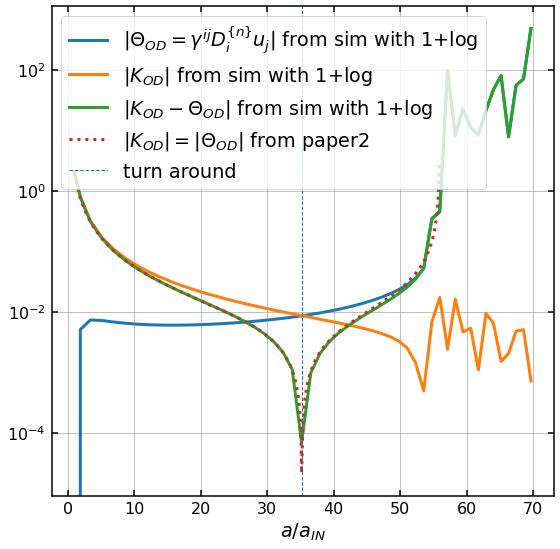

In [12]:
plt.figure(figsize=(9,9))
plt.semilogy(fdata['an_OD'], abs(np.array(ThetaOD)), label=r'$|\Theta_{OD}=\gamma^{ij}D^{\{n\}}_{i} u_{j}|$'+' from sim with 1+log')
plt.semilogy(fdata['an_OD'], abs(fdata['K_OD']), label=r'$|K_{OD}|$'+' from sim with 1+log')
plt.semilogy(fdata['an_OD'], abs(np.array(ThetaOD)-fdata['K_OD']), label=r'$|K_{OD}-\Theta_{OD}|$'+' from sim with 1+log')
plt.semilogy(Lin.an_initial(fA['t']), abs(fA['K_OD']), linestyle=':', label=r'$|K_{OD}|=|\Theta_{OD}|$'+' from paper2')
plt.axvline(x=35.195, linewidth=1, linestyle='--', label='turn around')
plt.legend(loc=2)
plt.grid()
plt.xlabel(r'$a/a_{IN}$')

# Look at fluid velocity

I expect $u_i = 0$ and $W = 1$

In [13]:
loc = {'OOO':(int(param['Nx']/4), int(param['Nx']/4), int(param['Nx']/4)),
       'OOC':(int(param['Nx']/4), int(param['Nx']/4), int(param['Nx']/2)),
       'OOU':(int(param['Nx']/4), int(param['Nx']/4), int(3*param['Nx']/4)),
       'OCO':(int(param['Nx']/4), int(param['Nx']/2), int(param['Nx']/4)),
       'OCC':(int(param['Nx']/4), int(param['Nx']/2), int(param['Nx']/2)),
       'OCU':(int(param['Nx']/4), int(param['Nx']/2), int(3*param['Nx']/4)),
       'OUO':(int(param['Nx']/4), int(3*param['Nx']/4), int(param['Nx']/4)),
       'OUC':(int(param['Nx']/4), int(3*param['Nx']/4), int(param['Nx']/2)),
       'OUU':(int(param['Nx']/4), int(3*param['Nx']/4), int(3*param['Nx']/4)),
       'COO':(int(param['Nx']/2), int(param['Nx']/4), int(param['Nx']/4)),
       'COC':(int(param['Nx']/2), int(param['Nx']/4), int(param['Nx']/2)),
       'COU':(int(param['Nx']/2), int(param['Nx']/4), int(3*param['Nx']/4)),
       'CCO':(int(param['Nx']/2), int(param['Nx']/2), int(param['Nx']/4)),
       'CCC':(int(param['Nx']/2), int(param['Nx']/2), int(param['Nx']/2)),
       'CCU':(int(param['Nx']/2), int(param['Nx']/2), int(3*param['Nx']/4)),
       'CUO':(int(param['Nx']/2), int(3*param['Nx']/4), int(param['Nx']/4)),
       'CUC':(int(param['Nx']/2), int(3*param['Nx']/4), int(param['Nx']/2)),
       'CUU':(int(param['Nx']/2), int(3*param['Nx']/4), int(3*param['Nx']/4)),
       'UOO':(int(3*param['Nx']/4), int(param['Nx']/4), int(param['Nx']/4)),
       'UOC':(int(3*param['Nx']/4), int(param['Nx']/4), int(param['Nx']/2)),
       'UOU':(int(3*param['Nx']/4), int(param['Nx']/4), int(3*param['Nx']/4)),
       'UCO':(int(3*param['Nx']/4), int(param['Nx']/2), int(param['Nx']/4)),
       'UCC':(int(3*param['Nx']/4), int(param['Nx']/2), int(param['Nx']/2)),
       'UCU':(int(3*param['Nx']/4), int(param['Nx']/2), int(3*param['Nx']/4)),
       'UUO':(int(3*param['Nx']/4), int(3*param['Nx']/4), int(param['Nx']/4)),
       'UUC':(int(3*param['Nx']/4), int(3*param['Nx']/4), int(param['Nx']/2)),
       'UUU':(int(3*param['Nx']/4), int(3*param['Nx']/4), int(3*param['Nx']/4))}

W = {}
u1 = {}
u2 = {}
u3 = {}
for loci in loc.keys():
    W[loci] = []
    u1[loci] = []
    u2[loci] = []
    u3[loci] = []
for it in fdata['it']:
    it = int(it)
    f = h5py.File('{}_it_{:06d}.hdf5'.format(it_file_name, it), 'r')
    
    u1data = RRead.cut0(RRead.fixij(f['CT_DUST::u1 it='+str(it)+' tl=0 rl=0']), 
                    param['ghost_size'], param['Nx'])
    u2data = RRead.cut0(RRead.fixij(f['CT_DUST::u2 it='+str(it)+' tl=0 rl=0']), 
                    param['ghost_size'], param['Nx'])
    u3data = RRead.cut0(RRead.fixij(f['CT_DUST::u3 it='+str(it)+' tl=0 rl=0']), 
                    param['ghost_size'], param['Nx'])
    Wcal = RRead.cut0(RRead.fixij(f['CT_DUST::W it='+str(it)+' tl=0 rl=0']), param['ghost_size'], param['Nx'])
    gdet = GV.get_the_metric(f, it)['gdet']
    Wdata = Wcal / np.sqrt(gdet)
    
    for loci in loc.keys():
        W[loci] += [Wdata[loc[loci]]]
        u1[loci] += [u1data[loc[loci]]]
        u2[loci] += [u1data[loc[loci]]]
        u3[loci] += [u1data[loc[loci]]]
        
for loci in loc.keys():
    W[loci] = np.array(W[loci])
    u1[loci] = np.array(u1[loci])
    u2[loci] = np.array(u2[loci])
    u3[loci] = np.array(u3[loci])

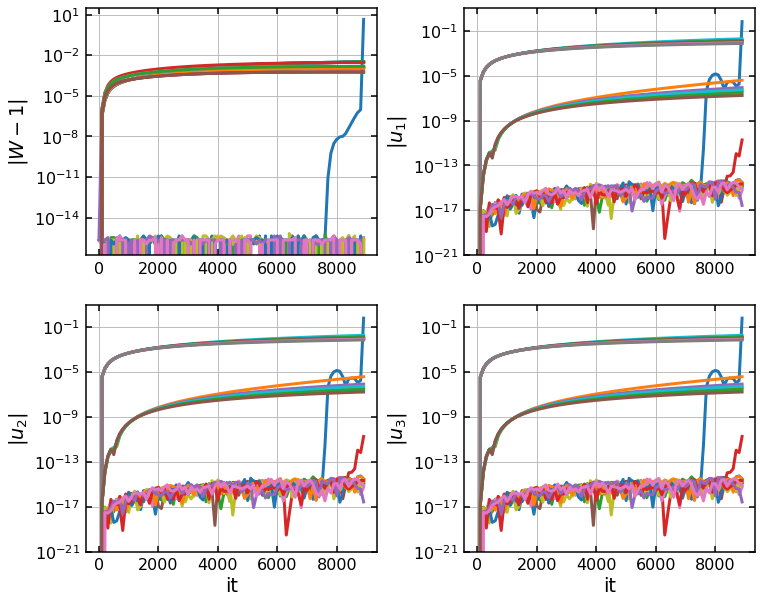

In [40]:
locs = list(loc.keys())

plt.figure(figsize=(12,10))
plt.subplot(221)
for loci in locs:
    plt.semilogy(fdata['it'], abs(W[loci] - 1))
plt.grid()
plt.ylabel(r'$|W - 1|$')

plt.subplot(222)
for loci in locs:
    plt.semilogy(fdata['it'], abs(u1[loci]), label=loci)
plt.grid()
#plt.legend(bbox_to_anchor=(1,1))
plt.ylabel(r'$|u_1|$')
plt.ylim(1e-21, 1e1)

plt.subplot(223)
for loci in locs:
    plt.semilogy(fdata['it'], abs(u2[loci]))
plt.grid()
plt.ylabel(r'$|u_2|$')
plt.xlabel('it')
plt.ylim(1e-21, 1e1)

plt.subplot(224)
for loci in locs:
    plt.semilogy(fdata['it'], abs(u3[loci]))
plt.grid()
plt.ylabel(r'$|u_3|$')
plt.xlabel('it')
plt.ylim(1e-21, 1e1)

plt.subplots_adjust(wspace = 0.3)